# Bi-color analysis

This notebook performs analysis of data quantified through `BC_clusterkinetics_pipeline.py`. It aims at analysing data with 2 samples condition (*eg. +/- puromycin*)

In [17]:
FIGSIZE = (15,15)
BINS = 100

EXPECTED_TREATMENT_NUMBER = 2
SIGNIFICANCE = 0.01

SINGLE_MOLECULES_KEYS = ["rna"]
OTHER_KEYS = ["treatment"]

PATH_IN= "/media/floricslimani/SSD4To/SSD_floricslimani/Fish_seq/Manon/240627 centrosome _golgi RNA FISH/merged_tables/"

Z_SCORE = 2.575829 # 99% confidence interval

## Open data & prepare folder

In [10]:
import pandas as pd

Acquisition = pd.read_feather(PATH_IN + '/Acquisition.feather')
Cell = pd.read_feather(PATH_IN + '/Cell.feather')

In [14]:
for table in [Acquisition, Cell] :
    if type(table['acquisition_id'].iat[0]) == list:
        table['acquisition_id'] = table['acquisition_id'].apply(tuple)

acq_columns = ['acquisition_id']

for col in ['rna','rna1', 'rna2', 'suntag', 'treatment'] :
    if col in Acquisition.columns :
        acq_columns.append(col)
        if col in Cell.columns : Cell = Cell.drop(columns=col)


Cell = pd.merge(
    Acquisition.loc[:,acq_columns],
    Cell,
    on= 'acquisition_id',
    how='right'
)

print(Cell.columns)


Index(['acquisition_id', 'rna', 'treatment', 'cell_id',
       'index_mean_distance_cell', 'index_median_distance_cell',
       'index_mean_distance_nuc', 'index_median_distance_nuc',
       'proportion_rna_in_nuc', 'nb_rna_out_nuc', 'nb_rna_in_nuc',
       'index_rna_protrusion', 'proportion_rna_protrusion', 'protrusion_area',
       'index_polarization', 'index_dispersion',
       'index_peripheral_distribution', 'index_rna_nuc_edge',
       'proportion_rna_nuc_edge', 'index_rna_nuc_radius_500_1000',
       'proportion_rna_nuc_radius_500_1000', 'index_rna_nuc_radius_1000_1500',
       'proportion_rna_nuc_radius_1000_1500', 'index_rna_nuc_radius_1500_2000',
       'proportion_rna_nuc_radius_1500_2000', 'index_rna_nuc_radius_2000_2500',
       'proportion_rna_nuc_radius_2000_2500', 'index_rna_nuc_radius_2500_3000',
       'proportion_rna_nuc_radius_2500_3000', 'index_rna_cell_radius_0_500',
       'proportion_rna_cell_radius_0_500', 'index_rna_cell_radius_500_1000',
       'proportion_

In [15]:
import os
PATH_OUT = PATH_IN.replace("result_tables", "analysis")
os.makedirs(PATH_OUT,exist_ok=True)

## (Opt) Renaming

### Renaming single molecules keys

In [5]:
mapping = {
    'rna1' : 'Cy3',
    'rna2' : 'Cy5',
}

for key in mapping.keys() : 
    assert key in SINGLE_MOLECULES_KEYS
    Cell.columns = Cell.columns.str.replace(key, mapping[key])

In [6]:
for index, value in enumerate(SINGLE_MOLECULES_KEYS.copy()) :
    if value in mapping.keys() : SINGLE_MOLECULES_KEYS[index] = mapping[value]
print(SINGLE_MOLECULES_KEYS)
print(Cell.columns)

['Cy3', 'Cy5', 'suntag']
Index(['acquisition_id', 'treatment', 'cell_id', 'index_mean_distance_cell',
       'index_median_distance_cell', 'index_mean_distance_nuc',
       'index_median_distance_nuc', 'proportion_rna_in_nuc', 'nb_rna_out_nuc',
       'nb_rna_in_nuc', 'index_rna_protrusion', 'proportion_rna_protrusion',
       'protrusion_area', 'index_polarization', 'index_dispersion',
       'index_peripheral_distribution', 'index_rna_nuc_edge',
       'proportion_rna_nuc_edge', 'index_rna_nuc_radius_500_1000',
       'proportion_rna_nuc_radius_500_1000', 'index_rna_nuc_radius_1000_1500',
       'proportion_rna_nuc_radius_1000_1500', 'index_rna_nuc_radius_1500_2000',
       'proportion_rna_nuc_radius_1500_2000', 'index_rna_nuc_radius_2000_2500',
       'proportion_rna_nuc_radius_2000_2500', 'index_rna_nuc_radius_2500_3000',
       'proportion_rna_nuc_radius_2500_3000', 'index_rna_cell_radius_0_500',
       'proportion_rna_cell_radius_0_500', 'index_rna_cell_radius_500_1000',
       '

## Renaming labels

In [7]:
mapping = {
    '' : 'empty',
}
UPPER_CASE = True

for key in SINGLE_MOLECULES_KEYS :
    Cell[key] = Cell[key].replace(mapping)
    if UPPER_CASE : Cell[key] = Cell[key].str.upper()

KeyError: 'Cy3'

In [8]:
for obj in SINGLE_MOLECULES_KEYS :
    print(obj)
    print(
        Cell[obj].unique()
    )

Cy3


KeyError: 'Cy3'

## Number of cell quantified

Output Excel extract to monitor how many cells were quantified for each conditions.

In [18]:
data = Cell.groupby(SINGLE_MOLECULES_KEYS + OTHER_KEYS)['cell_id'].count().rename('cell number')
print(data)
data.to_excel(PATH_OUT + "/quantified_cell_number.xlsx")

rna        treatment
AKAP9      CB16h         205
           dTAG2h        927
           unt           981
Ctl-empty  unt          1567
FLAP-ONLY  CB16h         689
           dTAG2h        659
Kif1C      CB16h         589
           dTAG2h        944
           unt          2779
NIN        CB16h         290
           dTAG2h        825
           unt          1002
NUMA       CB16h         409
           dTAG2h        507
           unt          1157
PCNT       CB16h         420
           dTAG2h        388
           unt           966
Name: cell number, dtype: int64


## Proportion of single molecules in foci (Treatment1 vs Treatment2).

This quantification is made to test if a significant difference is found in the proportion of single molecules in foci between 2 samples.

*ex : Puro vs Non puro*

In [19]:
assert len(Cell['treatment'].unique()) == 2, "This section is compatible only with 2 samples data"

import CustomPandasFramework.pvalues as pvalues
import pbwrap.plot as plot
import matplotlib.pyplot as plt
from pbwrap.plot.significance import add_significance
from CustomPandasFramework.Fish_seq.plot import compute_fraction_in_foci

os.makedirs(PATH_OUT + 'proportion_RNA_focci', exist_ok=True)

AssertionError: This section is compatible only with 2 samples data

### Compute fraction in foci

In [11]:
columns = SINGLE_MOLECULES_KEYS + OTHER_KEYS
for col in SINGLE_MOLECULES_KEYS : 
    columns += ['{0}_number'.format(col), '{0}_clustered_number'.format(col)]
data = Cell.loc[:, columns]

data = compute_fraction_in_foci(
    data,
    keys=SINGLE_MOLECULES_KEYS
)

for key in SINGLE_MOLECULES_KEYS : 
    extract = data.loc[(data['{0}_proportion_in_foci'.format(key)] > 1)] # Note that NaN are expected for cells where no spot were detected
    extract.to_excel(PATH_OUT + "/{0}_fraction_in_foci_error.xlsx".format(key))
    if len(extract) > 0 : print("Fraction of single in foci > 1 found for key : {0}".format(key))

### Compute p-values
Using t-test with correction for unequal variance.

In [12]:
pvalues_dict = {}

for key in SINGLE_MOLECULES_KEYS : 
    pvalues_dict[key] = pvalues.compute_Ttest(
        df = data,
        group_keys= [key,"treatment"],
        measure_keys= ["{0}_proportion_in_foci".format(key)],
    )

Extracting data to Exel files

In [16]:
data.reset_index(drop=True).to_excel(PATH_OUT + "/rna_in_foci_proportion.xlsx")

In [30]:
pd.concat(
    pvalues_dict.values(),axis=1
).to_excel(PATH_OUT + "/p_values_rna_in_foci_proportion.xlsx")

### Plotting proportion in foci

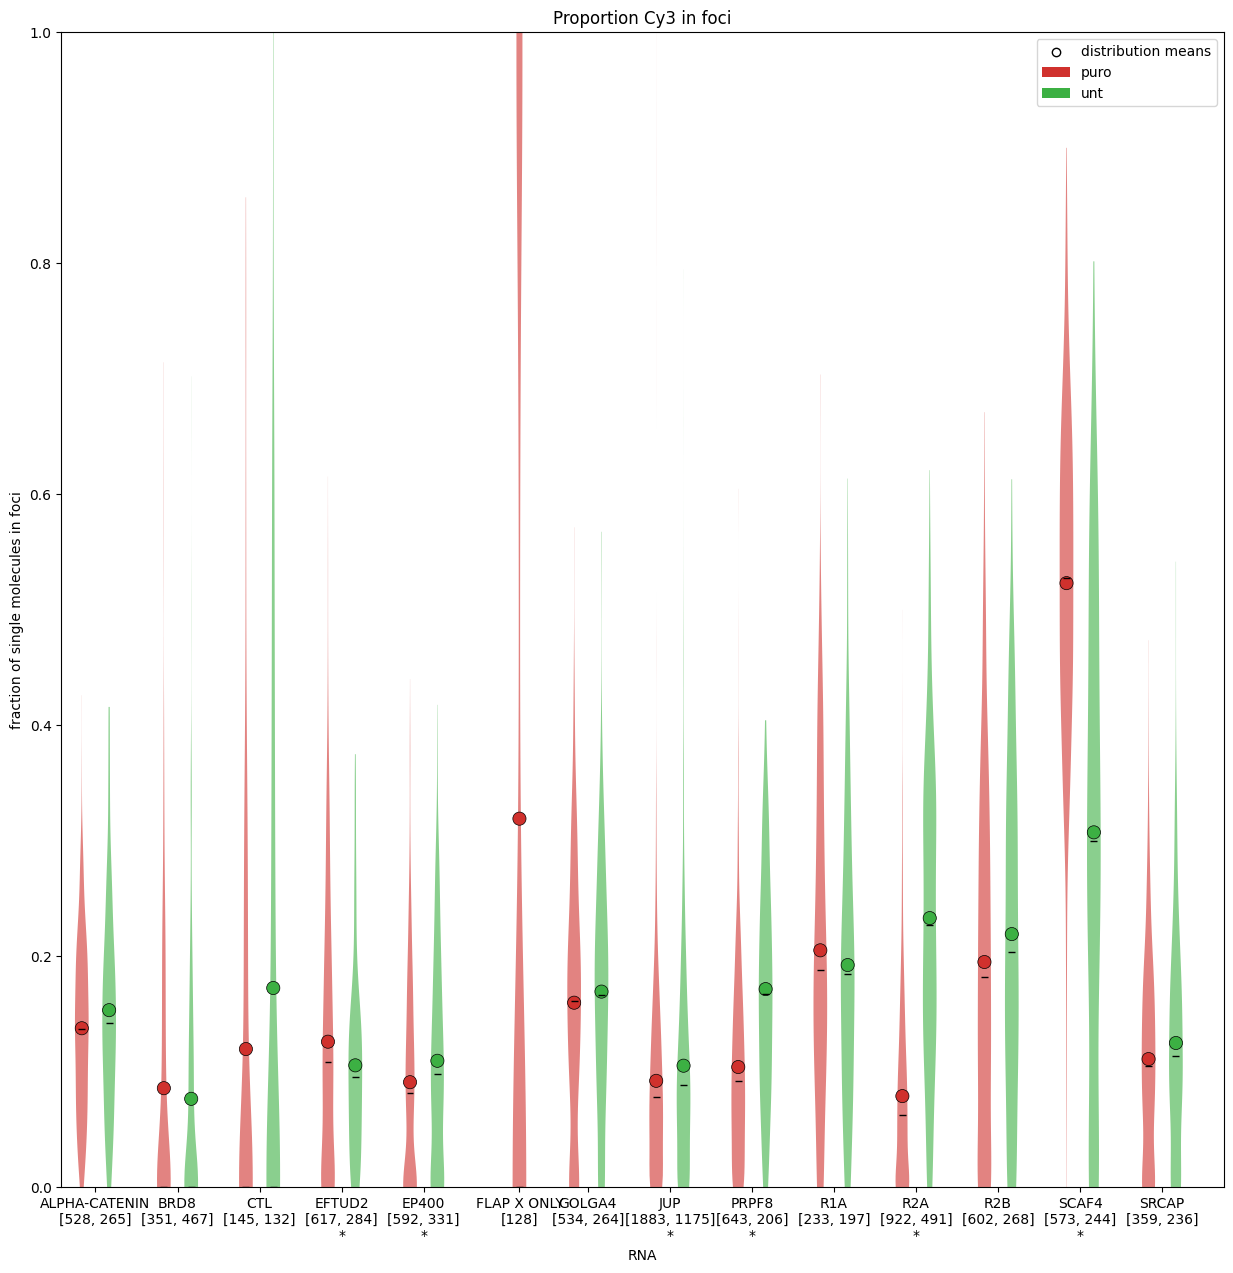

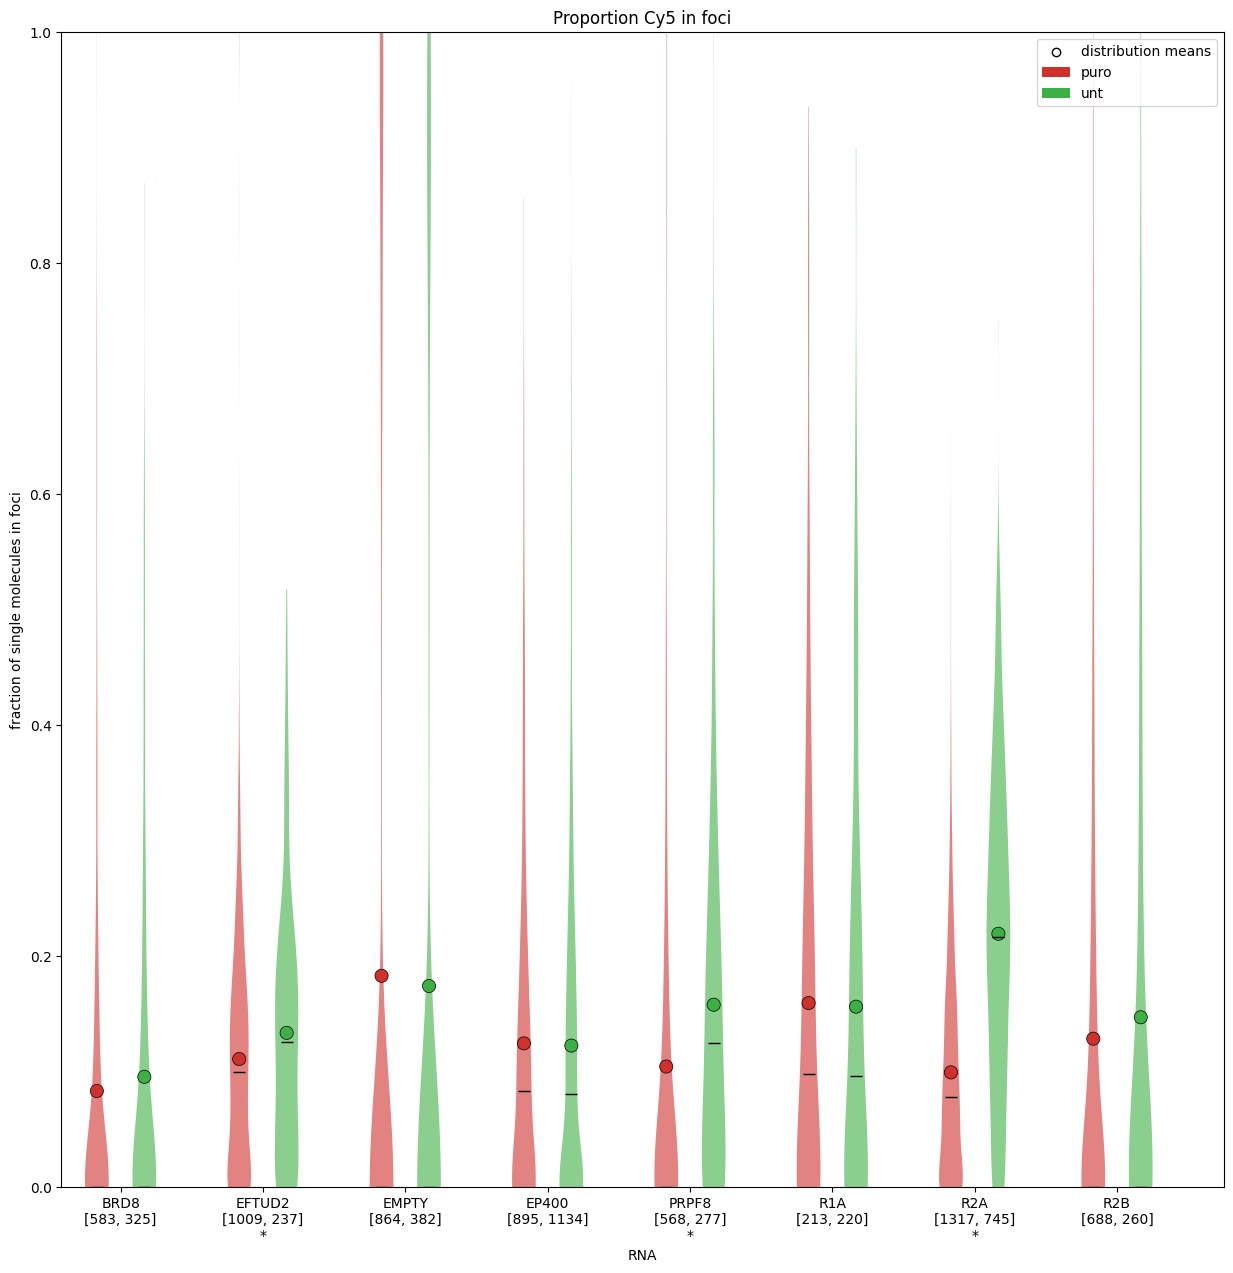

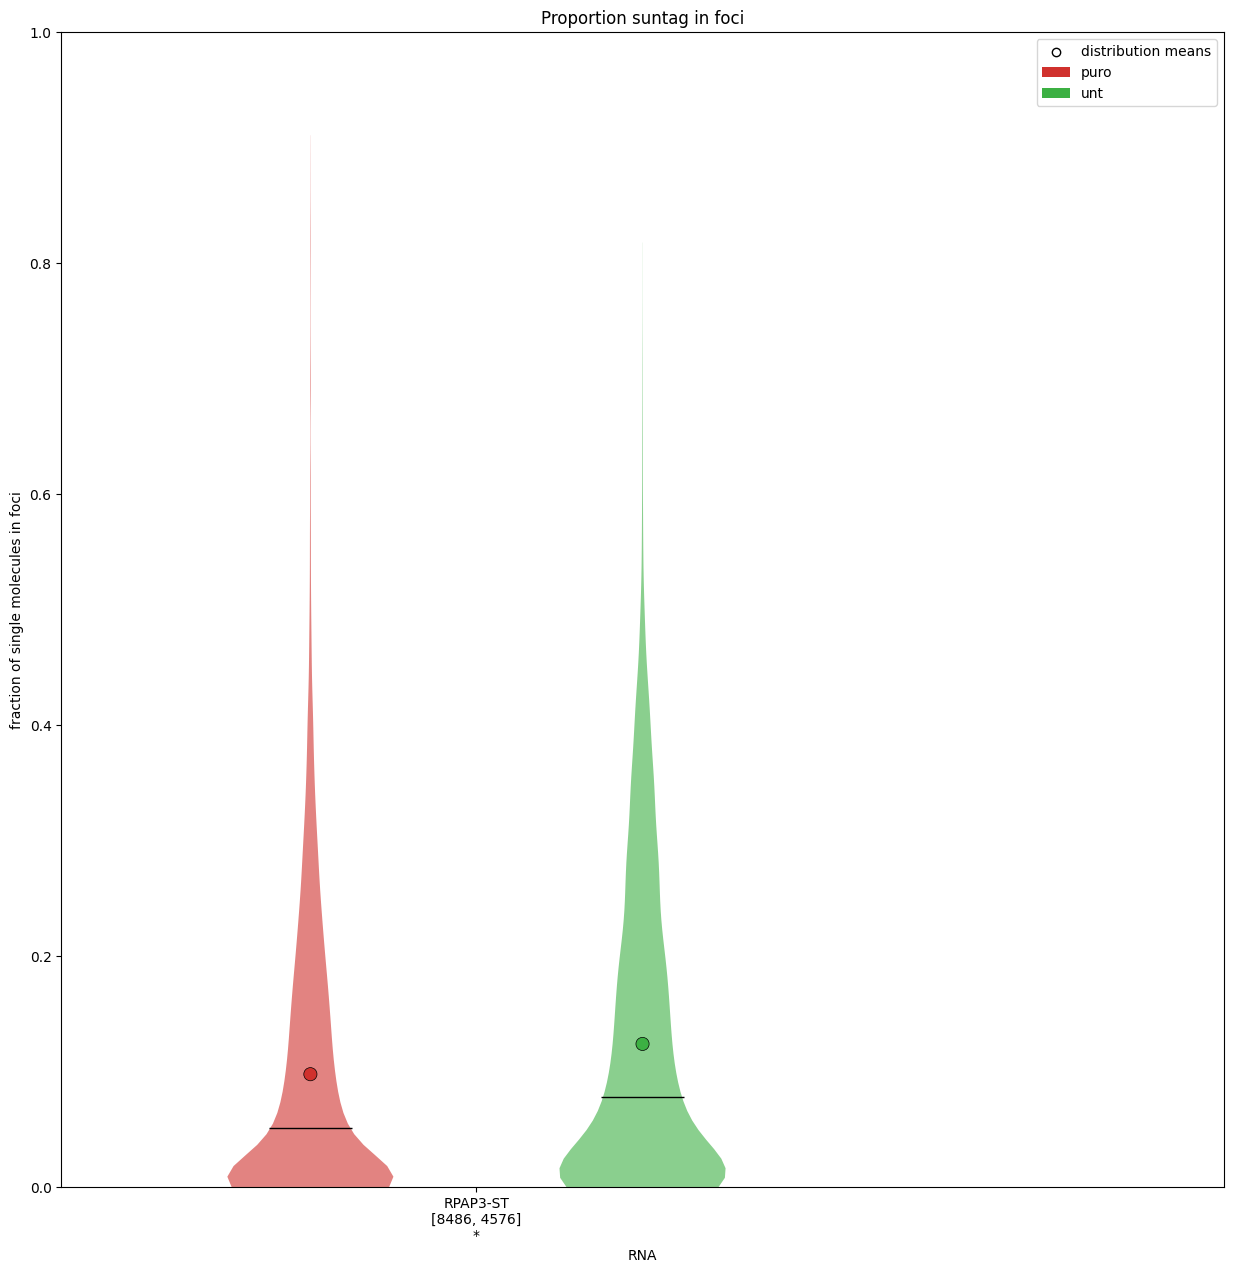

In [13]:
for key in SINGLE_MOLECULES_KEYS :
    sub_data = data.loc[:,[key, 'treatment','{0}_proportion_in_foci'.format(key)]].dropna()
    sub_data = sub_data.groupby([key,'treatment'])['{0}_proportion_in_foci'.format(key)].apply(list)
    fig = plt.figure(figsize= FIGSIZE)
    ax = fig.gca()
    ax = plot.distribution_super_plot(
        data=sub_data,
        ax=ax,
        title= 'Proportion {0} in foci'.format(key),
        xlabel= 'RNA',
        ylabel= 'fraction of single molecules in foci'
    )
    ax.set_ylim(bottom= 0, top=1)
    ax = add_significance(ax, pvalues_dict[key]["{0}_proportion_in_foci_pvalue".format(key)], significance= SIGNIFICANCE)

    fig.savefig(PATH_OUT + '/proportion_RNA_focci/proportion_{0}_in_foci.png'.format(key))
    plt.show(block=False)
    plt.close()

## General quantification distributions

### Single molecules per cell (Treatment1 vs Treatment2)

In [14]:
assert len(Cell['treatment'].unique()) == 2, "This section is compatible only with 2 samples data"

import CustomPandasFramework.pvalues as pvalues
import pbwrap.plot as plot
import matplotlib.pyplot as plt
from pbwrap.plot.significance import add_significance

os.makedirs(PATH_OUT + 'single_molecules_count_per_cell', exist_ok=True)

#### Computes p-values

In [15]:
pvalues_dict = {}

for key in SINGLE_MOLECULES_KEYS : 
    pvalues_dict[key] = pvalues.compute_Ttest(
        df = data,
        group_keys= [key,"treatment"],
        measure_keys= ["{0}_number".format(key)],
    )

#### Plot graphs

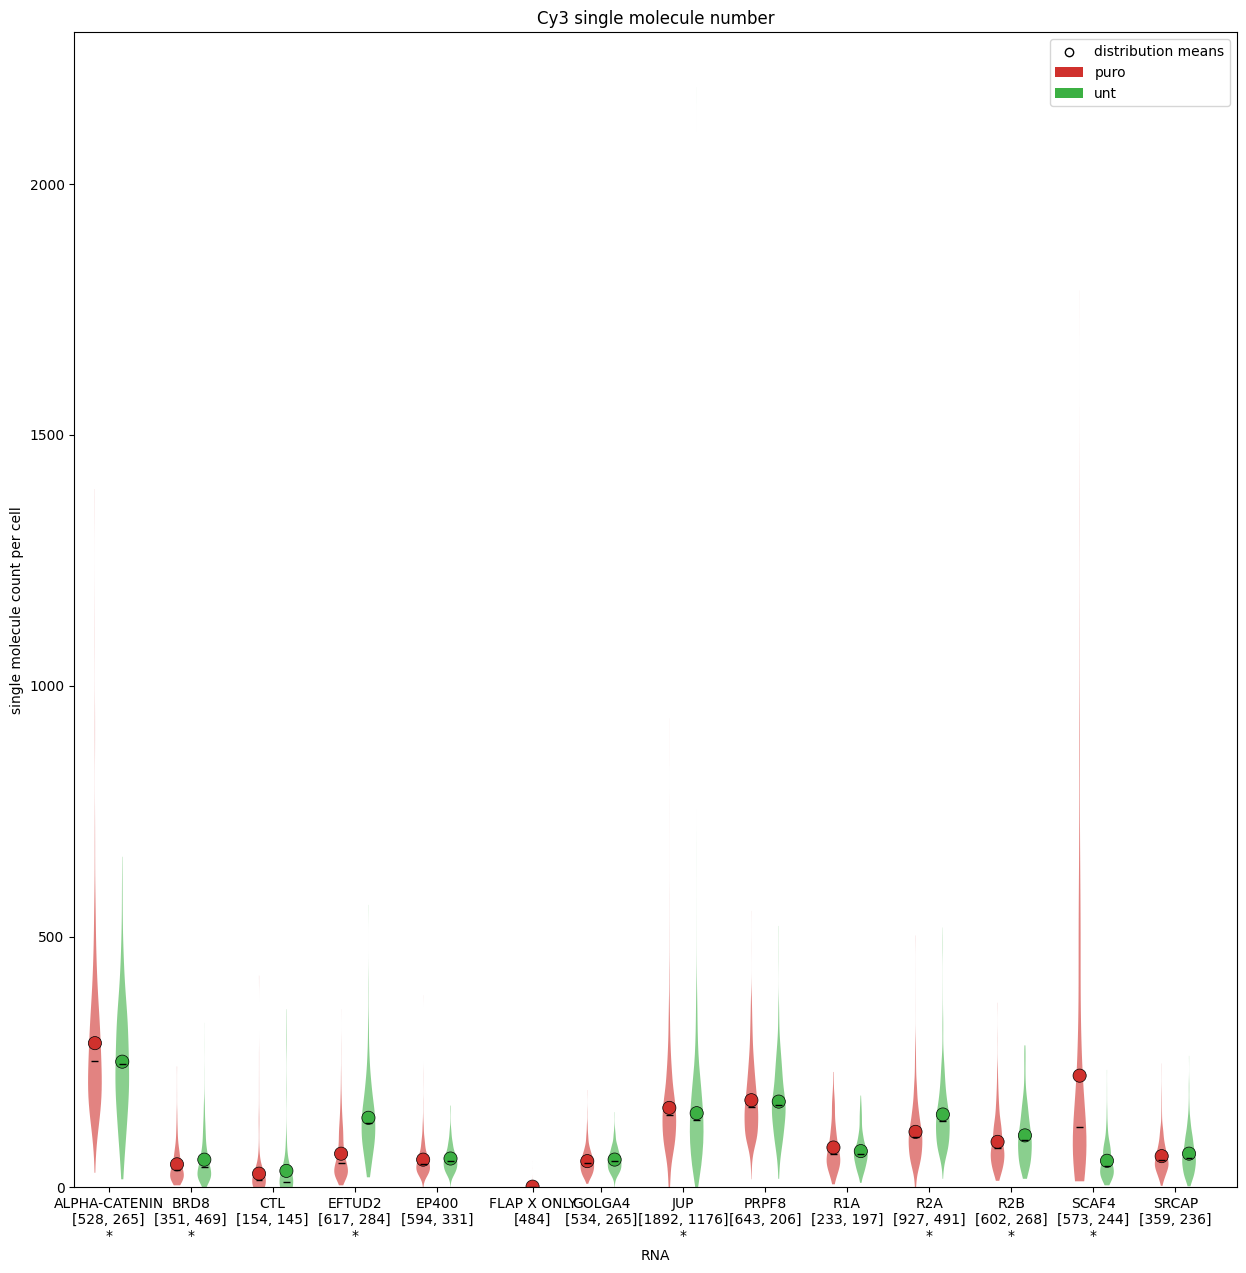

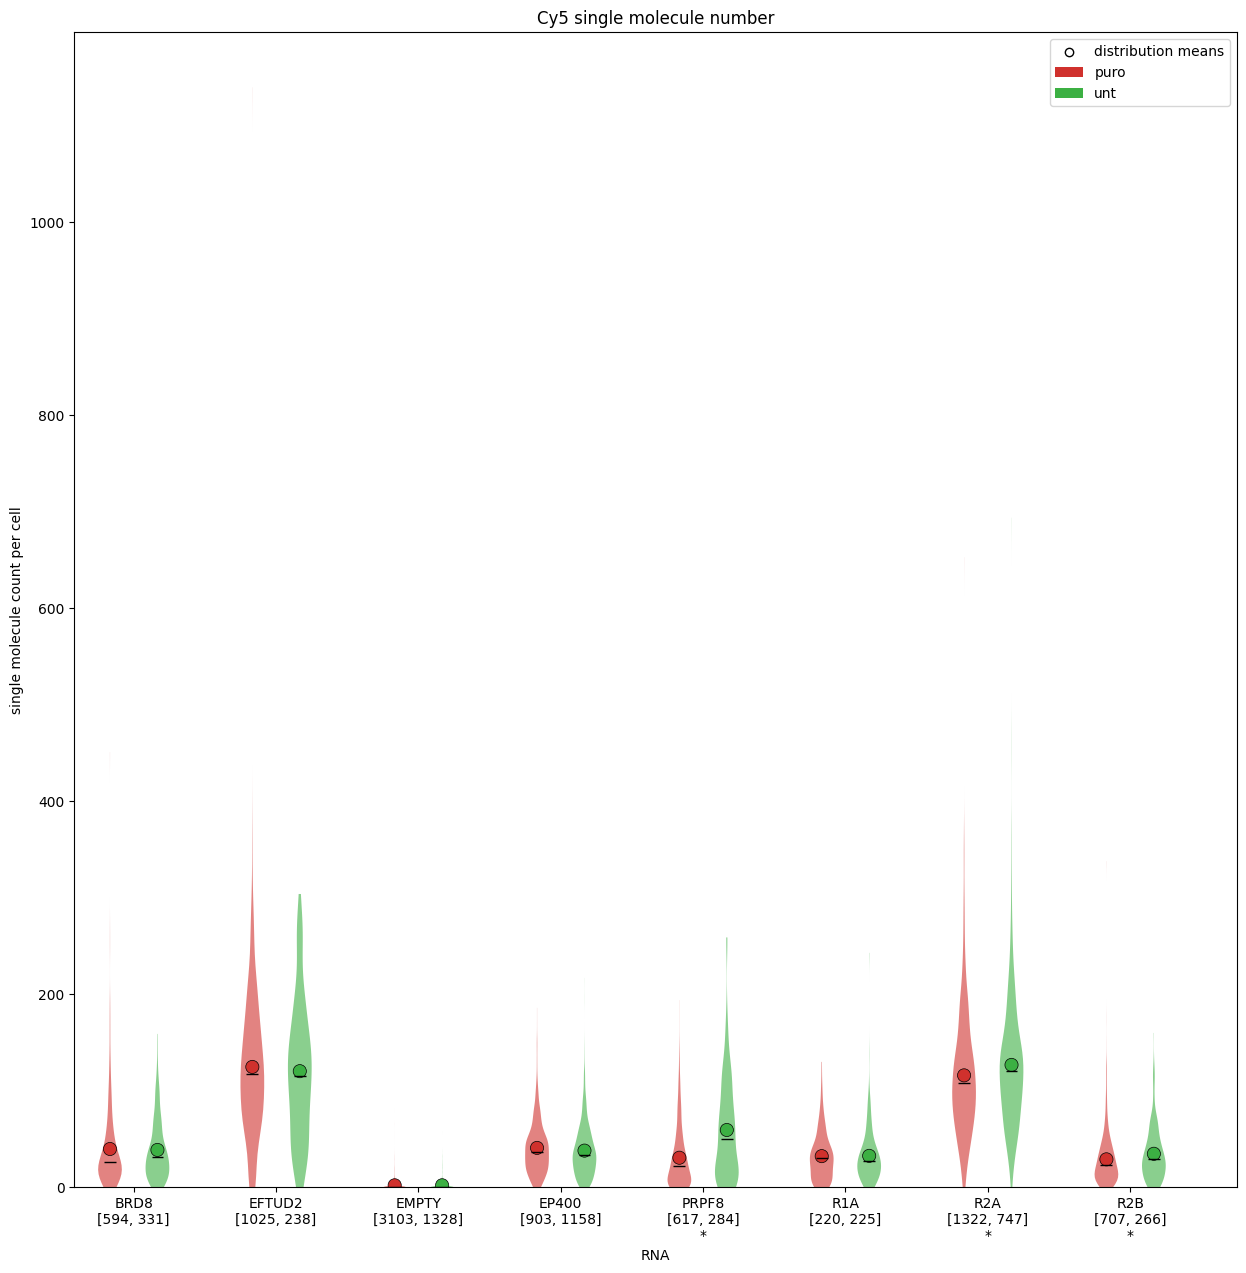

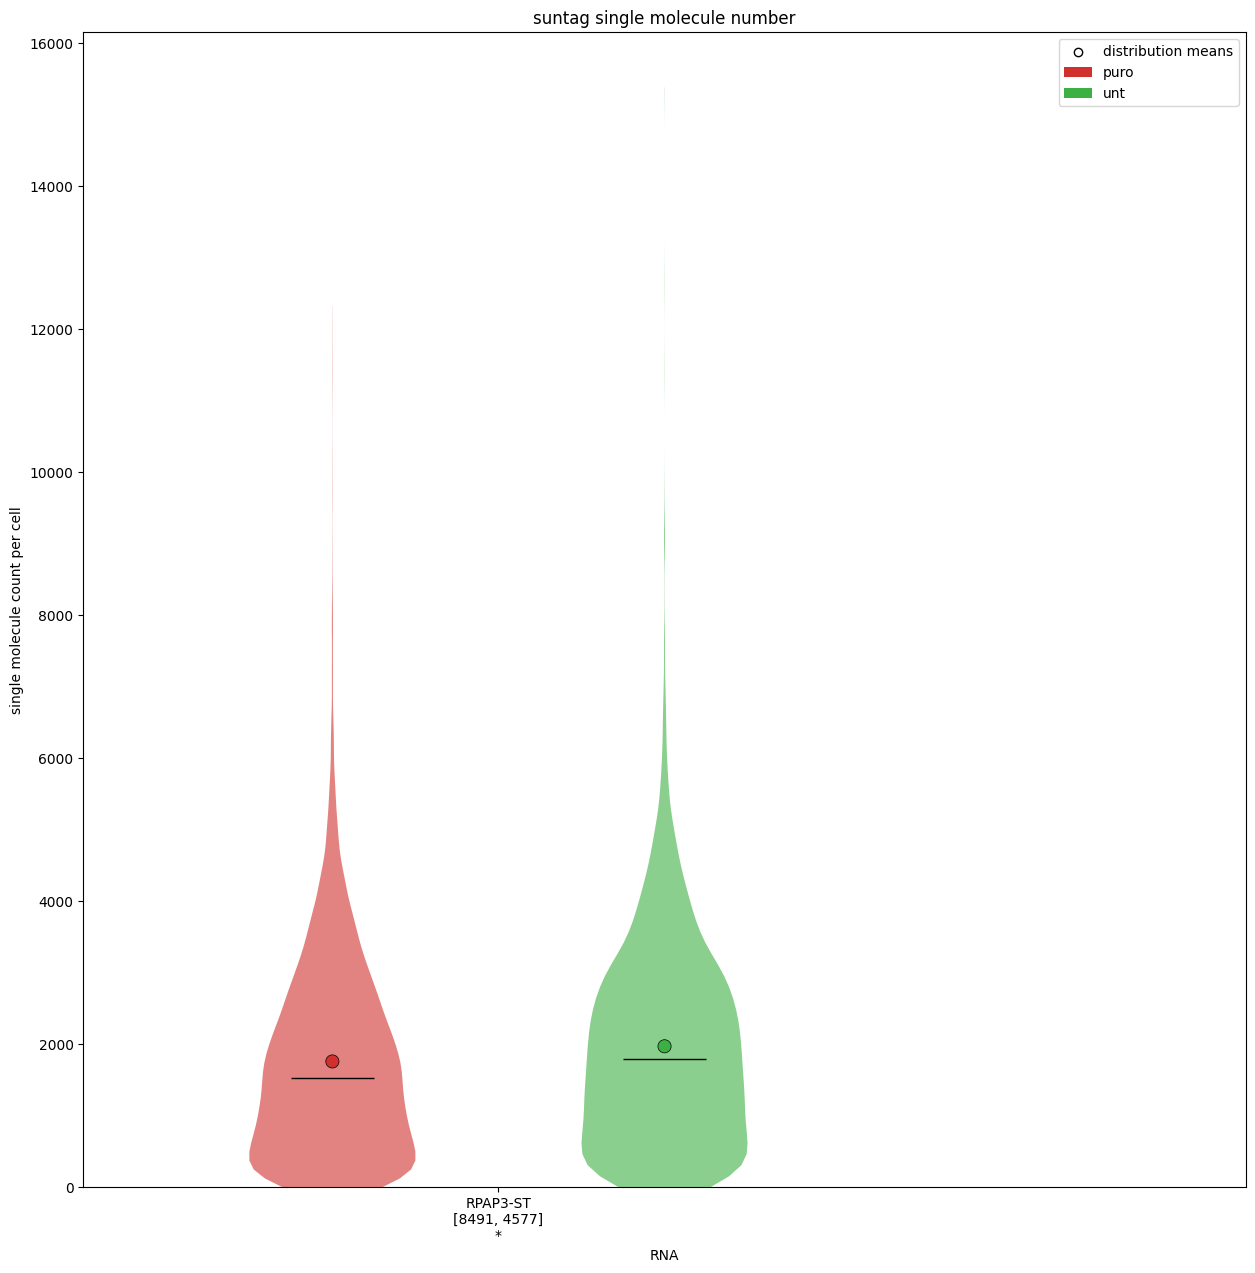

In [16]:
for key in SINGLE_MOLECULES_KEYS :
    sub_data = data.loc[:,[key, 'treatment','{0}_number'.format(key)]].dropna()
    sub_data = sub_data.groupby([key,'treatment'])['{0}_number'.format(key)].apply(list)
    fig = plt.figure(figsize= FIGSIZE)
    ax = fig.gca()
    ax = plot.distribution_super_plot(
        data=sub_data,
        ax=ax,
        title= '{0} single molecule number'.format(key),
        xlabel= 'RNA',
        ylabel= 'single molecule count per cell'
    )
    ax = add_significance(ax, pvalues_dict[key]["{0}_number_pvalue".format(key)], significance= SIGNIFICANCE)

    fig.savefig(PATH_OUT + '/single_molecules_count_per_cell/{0}_single_molecule_count.png'.format(key))
    plt.show(block=False)
    plt.close()

## Colocalization

This part computes the fraction of spots colocalizing and the significance between two sample treatments.

fractions are computed as follow : 



In [9]:
assert len(Cell['treatment'].unique()) == 2, "This section is compatible only with 2 samples data"

import CustomPandasFramework.pvalues as pvalues
import pbwrap.plot as plot
import matplotlib.pyplot as plt
import os
from itertools import product
from pbwrap.plot.significance import add_pvalue_star
from CustomPandasFramework.Fish_seq.plot import plot_coloc, save_fig_dict, add_pvalue

os.makedirs(PATH_OUT + '/colocalization/', exist_ok=True)

In [10]:
columns_dict = {}
populations = ['','_clustered','_free']
for obj1, obj2 in product(SINGLE_MOLECULES_KEYS,SINGLE_MOLECULES_KEYS) :
    if obj1 == obj2 : continue
    columns = [
        "{0}{2}_{1}{3}_colocalisation_count".format(obj1,obj2,pop1,pop2) for pop1,pop2 in product(populations,populations)
    ]
    columns_dict['{0}_{1}'.format(obj1,obj2)] = columns
    for col in columns : assert col in Cell.columns


### P-values

In [11]:

pvalues_dict = {}
for obj1, obj2 in product(SINGLE_MOLECULES_KEYS,SINGLE_MOLECULES_KEYS) :
    if obj1 == obj2 : continue
    pvalues_df = pvalues.compute_Ttest(
        df = Cell,
        group_keys= [obj1, obj2, "treatment"],
        measure_keys= columns_dict['{0}_{1}'.format(obj1,obj2)]
    )
    pvalues_dict['{0}_{1}'.format(obj1,obj2)] = pvalues_df

Extracting data to Excel

In [20]:
pd.concat(pvalues_dict.values(), axis= 1).to_excel(PATH_OUT + "/pvalues_colocalization_fraction.xlsx")

In [19]:
from CustomPandasFramework.Fish_seq import _coloc_get_target_columns, _compute_coloc_fractions

extract = pd.DataFrame()

for obj1, obj2 in product(SINGLE_MOLECULES_KEYS, SINGLE_MOLECULES_KEYS) :
    if obj1 == obj2 : continue
    target_columns = _coloc_get_target_columns(
        Cell,
        obj1_key=obj1,
        obj2_key=obj2,
        do_clustered_pop=True
    )

    fraction_frame, target_columns = _compute_coloc_fractions(
        Cell,
        target_columns,
        obj1,
        obj2,
        additional_grouping_keys= ['treatment']
    )
    extract = pd.concat([extract, fraction_frame], axis=1)
extract.to_excel(PATH_OUT + "/colocalization_fraction.xlsx")

### Versus Plots

In [14]:
for obj1, obj2 in product(SINGLE_MOLECULES_KEYS, SINGLE_MOLECULES_KEYS) :
    if obj1 == obj2 : continue
    coloc_dict = plot_coloc(
        dataframe=Cell,
        obj1_key=obj1,
        obj2_key=obj2,
        additional_grouping_keys= ['treatment'],
        do_clustered_pop=True,
    )
    pvalues_df = pvalues_dict['{0}_{1}'.format(obj1,obj2)]
    coloc_dict = add_pvalue(
        fig_dict=coloc_dict,
        pvalues=pvalues_df,
        do_clustered_pop=True
    )
    save_fig_dict(
        fig_dict=coloc_dict,
        obj_name='{0}_{1}'.format(obj1,obj2),
        output_folder=PATH_OUT
    )

### Overall plot

In [60]:
data = Cell.loc[:,SINGLE_MOLECULES_KEYS + OTHER_KEYS + sum(columns_dict.values(),[])]
print(data)

                 Cy3    Cy5    suntag treatment  Cy3_Cy5_colocalisation_count  \
0               BRD8  EP400  RPAP3-ST       unt                           1.0   
1               BRD8  EP400  RPAP3-ST       unt                           0.0   
2               BRD8  EP400  RPAP3-ST       unt                           1.0   
3               BRD8  EP400  RPAP3-ST       unt                           2.0   
4               BRD8  EP400  RPAP3-ST       unt                           0.0   
...              ...    ...       ...       ...                           ...   
13063  ALPHA-CATENIN  EMPTY  RPAP3-ST      puro                           NaN   
13064  ALPHA-CATENIN  EMPTY  RPAP3-ST      puro                           NaN   
13065  ALPHA-CATENIN  EMPTY  RPAP3-ST      puro                           NaN   
13066  ALPHA-CATENIN  EMPTY  RPAP3-ST      puro                           NaN   
13067  ALPHA-CATENIN  EMPTY  RPAP3-ST      puro                           NaN   

       Cy3_Cy5_clustered_co

In [58]:
coloc_index = []
coloc_columns = []
for key in SINGLE_MOLECULES_KEYS :
    coloc_index.extend(list(
        product([key], data[key].unique())
    ))
    for versus_key in SINGLE_MOLECULES_KEYS :
        if key == versus_key : continue
        sub_data = data.groupby(key)[versus_key].apply(list).apply(pd.unique).apply(list)
        sub_data = sum(list(sub_data),[])
        sub_col = product([versus_key],list(sub_data))
        coloc_columns.extend(sub_col)
        

In [59]:
coloc_array = pd.DataFrame(
    index=pd.MultiIndex.from_tuples(coloc_index),
    columns=pd.MultiIndex.from_tuples(coloc_columns)
)

print(coloc_array)

                       Cy5                                                  \
                     EMPTY EP400 EMPTY PRPF8 BRD8 EMPTY EMPTY EMPTY EFTUD2   
Cy3    BRD8            NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN    NaN   
       CTL             NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN    NaN   
       EFTUD2          NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN    NaN   
       EP400           NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN    NaN   
       FLAP X ONLY     NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN    NaN   
       GOLGA4          NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN    NaN   
       JUP             NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN    NaN   
       PRPF8           NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN    NaN   
       R1A             NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN    NaN   
       R2A             NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN    NaN   
       R2B             NaN   NaN   NaN   NaN  NaN   NaN   NaN   

In [ ]:
for obj1, obj2 in product(SINGLE_MOLECULES_KEYS, SINGLE_MOLECULES_KEYS) :
    if obj1 == obj2 : continue

    coloc_col = '{0}_{1}_colocalisation'